In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import joblib

In [3]:
df = pd.read_csv('diabetes.csv')
df_copy = df.copy()

#### EDA

In [4]:
df_copy.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


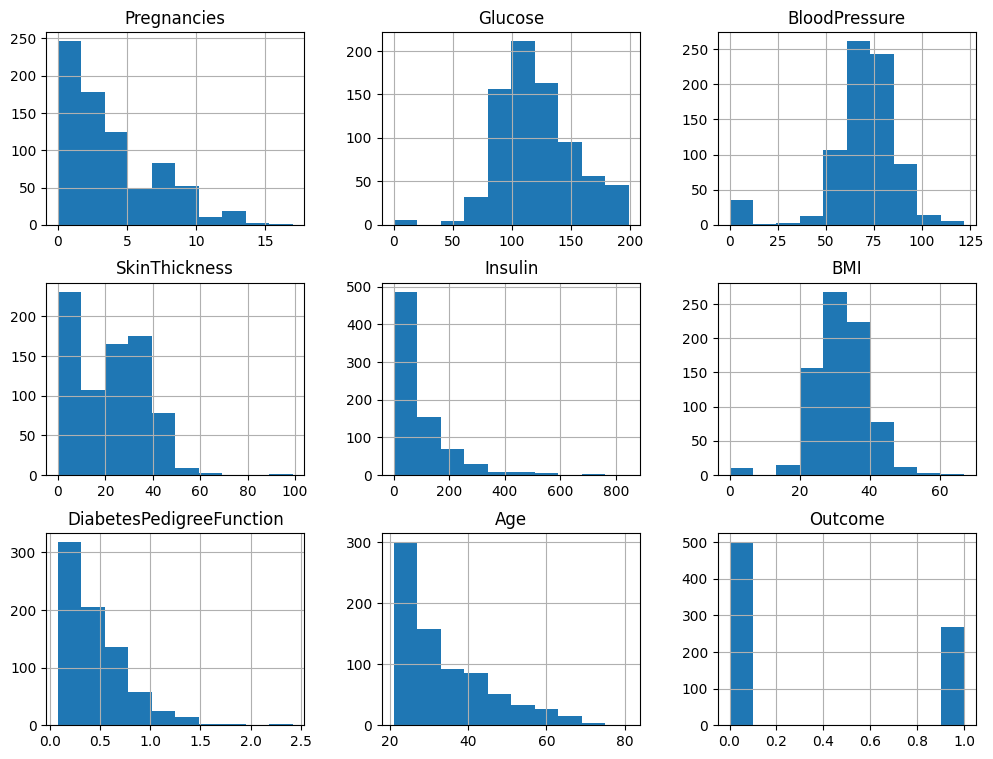

In [7]:
df_copy.hist(figsize=(12, 9))
plt.show()

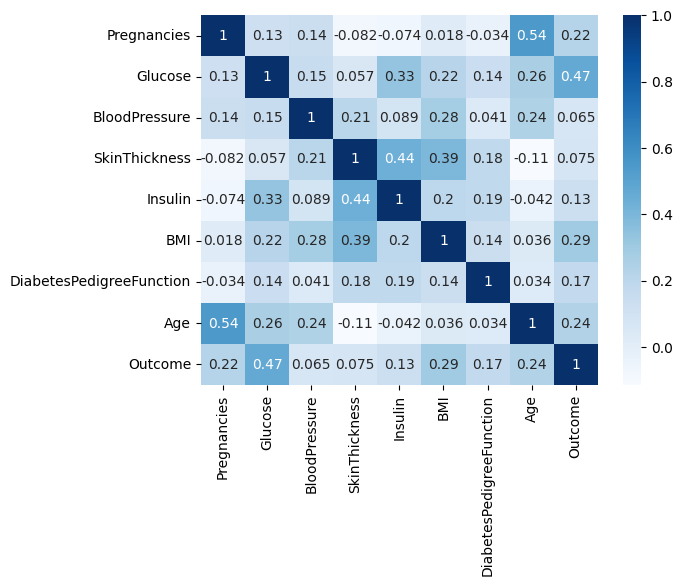

In [8]:
sns.heatmap(df_copy.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

#### Create a Test Set

In [9]:
strat_train, strat_test = train_test_split(df_copy, test_size=.2, 
                                           stratify=df_copy['Outcome'], 
                                           random_state=42)

In [10]:
strat_train_feats = strat_train.drop(columns='Outcome')
strat_train_labels = strat_train['Outcome'].copy()

#### Feature Engineering

In [11]:
def feat_eng(df):
    df['AgeCat'] = pd.cut(df['Age'],
                           bins=[0, 1, 12, 18, 65, np.inf],
                           labels=['infant', 'child', 'teenager', 'adult', 'older_adult'])

    df['BMICat'] = pd.cut(df['BMI'],
                            bins=[-np.inf, 18.5, 25, 30, np.inf],
                            labels=['underweight', 'normal', 'overweight', 'obese'])

    df['GlucoseCat'] = pd.cut(df['Glucose'],
                                bins=[-np.inf, 140, 200, np.inf],
                                labels=['normal', 'impaired', 'diabetic'])

    df['BloodPressCat'] = pd.cut(df['BloodPressure'],
                                    bins=[-np.inf, 80, 89, 120, 140],
                                    labels=['normal', 'stage_1', 'stage_2', 'Hypertensive_Crisis'])
    return df

In [12]:
strat_train_feats = feat_eng(strat_train_feats)
strat_train_feats

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,AgeCat,BMICat,GlucoseCat,BloodPressCat
353,1,90,62,12,43,27.2,0.580,24,adult,overweight,normal,normal
711,5,126,78,27,22,29.6,0.439,40,adult,overweight,normal,normal
373,2,105,58,40,94,34.9,0.225,25,adult,obese,normal,normal
46,1,146,56,0,0,29.7,0.564,29,adult,overweight,impaired,normal
682,0,95,64,39,105,44.6,0.366,22,adult,obese,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
451,2,134,70,0,0,28.9,0.542,23,adult,overweight,normal,normal
113,4,76,62,0,0,34.0,0.391,25,adult,obese,normal,normal
556,1,97,70,40,0,38.1,0.218,30,adult,obese,normal,normal
667,10,111,70,27,0,27.5,0.141,40,adult,overweight,normal,normal


In [34]:
strat_train_labels

353    0
711    0
373    0
46     0
682    0
      ..
451    1
113    0
556    0
667    1
107    0
Name: Outcome, Length: 614, dtype: int64

#### Pipelining

In [13]:
num_pl = Pipeline([
    ('imputenum', SimpleImputer(strategy='median')),
    ('stdscale', StandardScaler())
])

cat_pl = Pipeline([
    ('imputecat', SimpleImputer(strategy='most_frequent')),
    ('onehotencode', OneHotEncoder(handle_unknown='ignore'))
])

log_pl = Pipeline([
    ('imputelog', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('stdscalelog', StandardScaler())
])

In [14]:
preprocessing = make_column_transformer(
    (num_pl, ['Glucose', 'BloodPressure', 'BMI']),
    (log_pl, ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']),
    (cat_pl, make_column_selector(dtype_include='category'))
)

In [15]:
strat_train_feats_prep = pd.DataFrame(preprocessing.fit_transform(strat_train_feats), 
                                      columns=preprocessing.get_feature_names_out())

#### Try Various Models

In [16]:
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42))
sgd = make_pipeline(preprocessing, SGDClassifier(random_state=42))
dt = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42))
svm = make_pipeline(preprocessing, SVC(random_state=42))
rf = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))

In [17]:
models = [log_reg, sgd, dt, svm, rf]
for model in models:
    model.fit(strat_train_feats, strat_train_labels)

In [18]:
def calc_prec_recall(model):
    y_train_pred = cross_val_predict(model, strat_train_feats, strat_train_labels, cv=3)
    precesion = precision_score(strat_train_labels, y_train_pred)
    recall = recall_score(strat_train_labels, y_train_pred)
    print(f'{model.steps[-1][1].__class__.__name__}\nPrecesion: {precesion}\nRecall: {recall}\n')

In [19]:
for model in models:
    calc_prec_recall(model)

LogisticRegression
Precesion: 0.7090909090909091
Recall: 0.5467289719626168

SGDClassifier
Precesion: 0.6346153846153846
Recall: 0.46261682242990654

DecisionTreeClassifier
Precesion: 0.5388127853881278
Recall: 0.5514018691588785

SVC
Precesion: 0.7283950617283951
Recall: 0.5514018691588785

RandomForestClassifier
Precesion: 0.6783625730994152
Recall: 0.5420560747663551



#### Fine Tuning

In [20]:
full_pl = Pipeline([
    ('preprocessing', preprocessing),
    ('log_reg', LogisticRegression(random_state=42))
])

In [21]:
param_grid = [    
    {'log_reg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C' : np.logspace(-4, 4, 50),
    'log_reg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'log_reg__max_iter' : [100, 1000,2500, 5000]
    }
]

In [22]:
grid_search = GridSearchCV(full_pl, param_grid=param_grid, cv=4, n_jobs=3)
grid_search.fit(strat_train_feats, strat_train_labels)

/home/elneklawy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/elneklawy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/elneklawy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/elneklawy/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/elneklawy/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means t

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputenum',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('stdscale',
                                                                                          StandardScaler())]),
                                                                         ['Glucose',
                                                                          'BloodPressure',
                                                                          'BMI']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('imputelog',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer(feature_n...
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                          'log_reg__max_iter': [100, 1000, 2500, 5000],
                          'log_reg__penalty': ['l1', 'l2', 'elasticnet',
                                               'none'],
                          'log_reg__solver': ['lbfgs', 'newton-cg', 'liblinear',
                                              'sag', 'saga']}])

In [23]:
final_model = grid_search.best_estimator_

#### Test the Model on the Test Set

In [24]:
strat_test_feats = strat_test.drop(columns='Outcome')
strat_test_labels = strat_test['Outcome']

In [28]:
strat_test_feats = feat_eng(strat_test_feats)

In [31]:
y_test_pred = cross_val_predict(final_model, strat_test_feats, strat_test_labels, cv=3)
precesion = precision_score(strat_test_labels, y_test_pred)
recall = recall_score(strat_test_labels, y_test_pred)
precesion, recall

# I think this is somehow good given that the data set was very small

(0.625, 0.46296296296296297)

#### Save the Model

In [33]:
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']